In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path

from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics

import jax
import jax.numpy as jnp
from jax import jit

from pytorch_lightning.strategies import DDPStrategy

from paper_utils import LightningResNet18

import configparser
from paper_utils import PoincareDataModule, HenonMapPoincareDataModule

In [2]:
isBool = lambda x: x.lower() == "true"
converters = {'IntList': lambda x: [int(i.strip()) for i in x.strip(" [](){}").split(',')],
    'FloatList': lambda x: [float(i.strip()) for i in x.strip(" [](){}").split(',')],
    'BoolList': lambda x: [isBool(i.strip()) for i in x.strip(" [](){}").split(',')]}
config = configparser.ConfigParser(converters=converters)

coords=[0, 2]


In [29]:
config.read("./configs/model_training/SAM_study.cfg")
# LOGGING params
# -------------------------------------------------------
log_dir = config.get('LOGGING', 'log_dir')
name = config.get('LOGGING', 'name')
# -------------------------------------------------------
# HARDWARE params  
# -------------------------------------------------------  
num_workers = config.getint('HARDWARE', 'num_workers')
auto_select_gpus = config.getboolean('HARDWARE', 'auto_select_gpus')
num_gpus = config.getint('HARDWARE', 'num_gpus')

if auto_select_gpus==True:
    devices = num_gpus
else:
    devices = config.getIntList("HARDWARE", "devices")
if devices > 1:
    num_workers = 0
    strategy = DDPStrategy(find_unused_parameters=False)
else:
    num_workers = num_workers
    strategy = None
# -------------------------------------------------------
# DATAMODULE params
# -------------------------------------------------------
data_dir = config.get('DATAMODULE', 'data_dir')
main_lookup_dir = config.get('DATAMODULE', 'main_lookup_dir')
local_lookup_dir = config.get('DATAMODULE', 'local_lookup_dir')
batch_size = config.getint('DATAMODULE', 'batch_size')
img_widths = config.getIntList('DATAMODULE', 'img_width')
alpha = config.getfloat('DATAMODULE', 'alpha')
min_samples = config.getint('DATAMODULE', 'min_samples', fallback=0)
max_samples = config.getint('DATAMODULE', 'max_samples', fallback=-1)
min_traj_len = config.getint('DATAMODULE', 'min_traj_len')
max_traj_len = config.getint('DATAMODULE', 'max_traj_len')
num_params = config.getint('DATAMODULE', 'num_params')
if ("param_min" in config['DATAMODULE']) or ("param_max" in config['DATAMODULE']):
    if not (("param_min" in config['DATAMODULE']) and ("param_max" in config['DATAMODULE'])):
        raise ValueError("Must specify both param_min and param_max, or neither")
    else:
        param_min = np.array(config.getFloatList('DATAMODULE', 'param_min'))
        param_max = np.array(config.getFloatList('DATAMODULE', 'param_max'))
        assert(num_params == len(param_min) == len(param_max))
else:
    param_min = None
    param_max = None

coords = config.getIntList('DATAMODULE', 'coords', fallback=[0,1])
print(f"{coords=}")
x_range = config.getFloatList('DATAMODULE', 'x_range', fallback=None)
y_range = config.getFloatList('DATAMODULE', 'y_range', fallback=None)

coords=[0, 2]


In [31]:
trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=devices,
    num_sanity_val_steps=0,
    deterministic=True,
    auto_select_gpus=auto_select_gpus,
    enable_progress_bar=False
)

assert(len(img_widths) == 1)

sample_frac = 1.

aug_datamodule = PoincareDataModule(
                    local_lookup_dir=local_lookup_dir,
                    data_dir=data_dir,
                    coords=coords,
                    sample_frac=sample_frac,
                    img_width=img_widths[0],
                    batch_size=batch_size, 
                    x_range=x_range,
                    y_range=y_range,
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=min_traj_len,
                    max_traj_len=max_traj_len,
                    num_workers=num_workers,
                    verbose=True,
                    randomize=True,
                )
                    
non_aug_datamodule = PoincareDataModule(
                local_lookup_dir=local_lookup_dir,
                data_dir=data_dir,
                coords=coords,
                sample_frac=sample_frac,
                img_width=img_widths[0],
                batch_size=batch_size, 
                x_range=x_range,
                y_range=y_range,
                alpha=alpha,
                min_samples=min_samples,
                max_samples=max_samples,
                min_traj_len=min_traj_len,
                max_traj_len=max_traj_len,
                num_workers=num_workers,
                verbose=True,
                randomize=False,
            )

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


In [32]:
df_list = []
p = Path(log_dir)
for i in p.rglob('*.yaml'):
    # parse file to get number of training samples used, and whether or not it was randomized
    hparam_dict = yaml.safe_load(i.open())
    num_train = hparam_dict['num_train']
    randomized = hparam_dict['randomize']
    print(f"{num_train=}, {randomized=}")
    for child in i.parent.iterdir():
        if child.is_dir():
            for model_ckpt in child.iterdir():
                model = LightningResNet18.load_from_checkpoint(model_ckpt.resolve())
                datamodule = aug_datamodule if randomized else non_aug_datamodule
                test_loss = trainer.test(model=model, dataloaders=datamodule.test_dataloader(), verbose=False)[0]["val_mse"]
                df_list.append({"loss": test_loss, "num_train": num_train, "Train Augmentation": randomized})
SAM_df = pd.DataFrame(df_list)

num_train=3840, randomized=False


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=3840, randomized=True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=1920, randomized=False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=1920, randomized=True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=960, randomized=False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=960, randomized=True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=240, randomized=False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=240, randomized=True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=120, randomized=False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=120, randomized=True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=480, randomized=False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


num_train=480, randomized=True


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Text(0, 0.5, 'Test MSE')

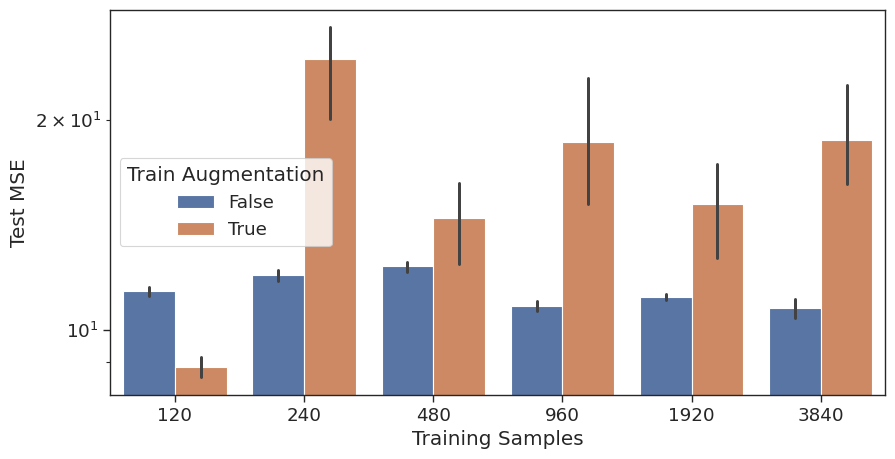

In [33]:
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_yscale("log")
# df = pd.read_csv("sample_efficiency_trials.csv")
sns.barplot(data=SAM_df, x="num_train", y="loss", hue="Train Augmentation")

ax.set_xlabel("Training Samples")
ax.set_ylabel(f"Test MSE")
# plt.savefig("efficiency_study_test_MSE.pdf", bbox_inches="tight")

In [22]:
# config.read("./configs/model_training/henon_map_study.cfg")
# # LOGGING params
# # -------------------------------------------------------
# log_dir = config.get('LOGGING', 'log_dir')
# name = config.get('LOGGING', 'name')
# # -------------------------------------------------------
# # HARDWARE params  
# # -------------------------------------------------------  
# num_workers = config.getint('HARDWARE', 'num_workers')
# auto_select_gpus = config.getboolean('HARDWARE', 'auto_select_gpus')
# num_gpus = config.getint('HARDWARE', 'num_gpus')

# if auto_select_gpus==True:
#     devices = num_gpus
# else:
#     devices = config.getIntList("HARDWARE", "devices")
# if devices > 1:
#     num_workers = 0
#     strategy = DDPStrategy(find_unused_parameters=False)
# else:
#     num_workers = num_workers
#     strategy = None
# # -------------------------------------------------------
# # DATAMODULE params
# # -------------------------------------------------------
# data_dir = config.get('DATAMODULE', 'data_dir')
# main_lookup_dir = config.get('DATAMODULE', 'main_lookup_dir')
# local_lookup_dir = config.get('DATAMODULE', 'local_lookup_dir')
# batch_size = config.getint('DATAMODULE', 'batch_size')
# img_widths = config.getIntList('DATAMODULE', 'img_width')
# alpha = config.getfloat('DATAMODULE', 'alpha')
# min_samples = config.getint('DATAMODULE', 'min_samples', fallback=0)
# max_samples = config.getint('DATAMODULE', 'max_samples', fallback=-1)
# min_traj_len = config.getint('DATAMODULE', 'min_traj_len')
# max_traj_len = config.getint('DATAMODULE', 'max_traj_len')
# a_range = config.getFloatList('DATAMODULE', 'a_range')
# b_range = config.getFloatList('DATAMODULE', 'b_range')

# coords = config.getIntList('DATAMODULE', 'coords', fallback=[0,1])
# print(f"{coords=}")
# x_range = config.getFloatList('DATAMODULE', 'x_range', fallback=None)
# y_range = config.getFloatList('DATAMODULE', 'y_range', fallback=None)

coords=[0, 1]


In [36]:
# trainer = pl.Trainer(
#     logger=False,
#     accelerator='gpu',
#     devices=devices,
#     num_sanity_val_steps=0,
#     deterministic=True,
#     auto_select_gpus=auto_select_gpus,
#     enable_progress_bar=False
# )

# assert(len(img_widths) == 1)

# aug_datamodule = HenonMapPoincareDataModule(
#                     num_samples=1000,
#                     batch_size=32, 
#                     a_range=a_range,
#                     b_range=b_range,
#                     x_range=x_range,
#                     y_range=y_range,
#                     img_width=128,
#                     alpha=.7,
#                     min_samples=10,
#                     max_samples=225,
#                     min_traj_len=min_traj_len,
#                     num_iters=max_traj_len,
#                     num_workers=num_workers,
#                     verbose=False,
#                     randomize=True)
                    
# non_aug_datamodule = HenonMapPoincareDataModule(
#                 num_samples=1000,
#                 batch_size=32, 
#                 a_range=a_range,
#                 b_range=b_range,
#                 x_range=x_range,
#                 y_range=y_range,
#                 img_width=128,
#                 alpha=.7,
#                 min_samples=min_samples,
#                 max_samples=max_samples,
#                 min_traj_len=min_traj_len,
#                 num_iters=max_traj_len,
#                 num_workers=num_workers,
#                 verbose=False,
#                 randomize=False)

In [ ]:
# df_list = []
# p = Path(log_dir)
# for i in p.rglob('*.yaml'):
#     # parse file to get number of training samples used, and whether or not it was randomized
#     hparam_dict = yaml.safe_load(i.open())
#     num_train = hparam_dict['num_train']
#     randomized = hparam_dict['randomize']
#     print(f"{num_train=}, {randomized=}")
#     for child in i.parent.iterdir():
#         if child.is_dir():
#             for model_ckpt in child.iterdir():
#                 model = LightningResNet18.load_from_checkpoint(model_ckpt.resolve())
#                 datamodule = aug_datamodule if randomized else non_aug_datamodule
#                 test_loss = trainer.test(model=model, dataloaders=datamodule.test_dataloader(), verbose=False)[0]["val_mse"]
#                 df_list.append({"loss": test_loss, "num_train": num_train, "Train Augmentation": randomized})
# henon_df = pd.DataFrame(df_list)

In [ ]:
# sns.set_theme(context="paper", style="ticks", font_scale=1.5)
# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.set_yscale("log")
# # df = pd.read_csv("sample_efficiency_trials.csv")
# sns.barplot(data=henon_df, x="num_train", y="loss", hue="Train Augmentation")

# ax.set_xlabel("Training Samples")
# ax.set_ylabel(f"Test MSE")
# # plt.savefig("efficiency_study_test_MSE.pdf", bbox_inches="tight")